In [2]:
# settings and modules
%config InlineBackend.figure_format = 'retina'
%pylab inline
from nsaba.nsaba import nsaba

Populating the interactive namespace from numpy and matplotlib


# Nsaba Walkthrough

NSABA (NeuroSynth Allen Brain Atlas) is a python module with a suite of tools for analyzing fMRI meta-analyses from Neurosynth (http://neurosynth.org) and brain-wide, genome-scale human gene experession data from the Allen Brain Institute (http://human.brain-map.org/)

This tool can be used to [estimate gene expression or term association with given coordinates](#Estimation), [visualize relationships between gene expression and term association](#Visualization), and [perform several analyses on these data](#Analysis)

In other words, this tool can ask questions such as, "Is the D2 receptor expressed significantly higher in brain regions that are activated in studies that talk about 'reward'?"
[Moreover, this tool can be used to algorithmically generate novel hypotheses about genes and functional networks](#Scraping)

This notebook will demonstrate some of the functionality of the Nsaba toolbox to explore the relationship between D2 receptors and parts of the brain associated with reward. This is the long demo. For a shorter walkthrough see the Short Demo notebook in this Repo.

# Table of Contents

* [Base Module](#Base)

* [Estimating Gene Expression and Term Activation](#Estimation)

* [Visualization Module](#Visualization)

* [Plotting Correlations between single terms and genes](#Correlations)

* [Analysis Module](#Analysis)

* [GeneInfo Module](#Base)

* [Builder Module](#Base) (in development)


<a id="Base"></a>
# The Nsaba() base Module


**Estimation Methods:**

* estimate_aba_ge(entrez_ids, coords=None, **kwargs): Retrieves, estimates and stores gene expression coefficients in ABA dictionary based on a passed list of NIH Entrez IDs.

* estimate_ns_act(self, term, coords=None, **kwargs): Uses radius neighbors regression to estimate Neurosynth term activation (tf-idf) at specified coordinates. If no coordinates are passed, ABA sampled locations in corresponding NsabaBase are used.

**Organization Methods**

* matrix_builder(ns_terms=None,entrez_ids=None): Generates a np.array() matrix of pre-estimated term activations and gene expression coefficients.

* ge_ratio(self, entrez_ids, coords=None, **kwargs): Calculates the ratio of gene expression at each ABA sampled MNI coordinate or custom coordinates.

**Initialization Methods:**

* aba_load(aba_path='.', csv_names=None): loads data from the ABA into dataframes.

* ns_load(ns_path='.', ns_files=None): loads data from NS into dataframes.

* load_ge_pkl(pkl_file="Nsaba_ABA_ge.pkl", output_dir='.'): loads a previously saved pkl file of genetic expression. Faster than aba_load for a series of genes.

* load_ns_pkl(pkl_file="Nsaba_NS_act.pkl", output_dir='.'): loads a previously saved pkl file of term activation. Faster than ns_load for a series of terms.

**Bookkeeping Methods:**

* _check_static_members(): Reminds the user to run aba_load and ns_load before doing anything 

* check_entrez_struct(entrez_ids): checks that entrez_id's are entered in the correct format

* is_term(term): checks that a term exists in the NS term library

* is_coord((x,y,z)): checks if a coordinate set has a matching neurosynth study ID

* is_id(study_id): checks if a study ID matches the Neurosynth database. The two dataframes, one with coordinates and one with activation vectors have some mismatched ID's.

* coord_to_ids((x,y,z)): finds study IDs with coordinates that match (x,y,z)

* coord_to_terms((x,y,z)): returns the mean activation of all terms at coordinates (x,y,z). If there is no activation data at these coordinates, it returns []

* _coord_to_ge(coord, ids, search_radii, k): returns the estimated gene expression of a gene at a coordinate using the knn method (described below)

* _id_to_terms(study_id): returns the vector of term activations for a NS study

* id_to_coords. Not a method. Use id_dict.

* _term_to_coords(term, thresh=0): returns coordinates where a term activation is above a given threshold. set thresh to -1 for all activation.

* pickle_ge(pkl_file="Nsaba_ABA_ge.pkl", path='.'): Saves Current ABA data to a pkl file.
* pickle_ns(pkl_file="Nsaba_NS_act.pkl", path='.'): Saves Current term data to a pkl file.

* ns_load_id_dict(): builds a dictionary of NS study ids with their corresponding coordinates. Helpful for NS methods where lots of overlapping data has to be accessed. 



## Initializing a Nsaba object

In [3]:
#local paths to data
ns_path = "/Users/Torben/Documents/ABI analysis/current_data_new/"
aba_path = '/Users/Torben/Documents/ABI analysis/normalized_microarray_donor9861/'

#initialization methods
nsaba.Nsaba.ns_load(ns_path)
nsaba.Nsaba.aba_load(aba_path)

#Creating Nsaba object and loading previously estimated gene activation values
N = nsaba.Nsaba()
N.load_ge_pickle(pkl_file ='/Users/Torben/Documents/ABI analysis/normalized_microarray_donor9861/Nsaba_ABA_ge.pkl')
N.load_ns_pickle(pkl_file= '/Users/Torben/Documents/Nsaba_NS_act_final.pkl')

This may take a minute or two ...
database.txt loaded.
features.txt loaded.
Nsaba.ns['mni_coords'] initialized.

This may take a minute or two ...
SampleAnnot.csv loaded.
MicroarrayExpression.csv loaded.
Probes.csv loaded.
Nsaba.aba['mni_coords'] initialized.

This may take a minute or two...
'ge' dictionary successfully loaded
This may take a minute or two ...
term dictionary successfully loaded


## Gathering data for two genes and two terms
* 'Reward' and 'Motivation' - Words used to describe behaviors associated with basal ganglia circuitry
* entrez ID: 1813 - DRD2, the gene that encodes the D2 dopamine receptor
* entrez ID: 6531 - SLC6A3, a gene that encodes the dopamine transporter

Code from the cell below will initialize data for these terms and genes.

In [4]:
from nsaba.nsaba import geneinfo
term1 = 'reward'
term2 = 'motivation'
genes = [1813 , 6531]

#local path to csv file of gene information scraped from the NIH database 
#(see geneInfo section near end of notebook)
gene_info_output =  geneinfo.get_local_gene_info('/Users/Torben/Code/nsaba/csv/',genes)
for info in gene_info_output:
    print info,'\n'

gi_tuple(entrez=1813, name='dopamine receptor D2', description="[u'This gene encodes the D2 subtype of the dopamine receptor. This G-protein coupled receptor inhibits adenylyl cyclase activity. A missense mutation in this gene causes myoclonus dystonia; other mutations have been associated with schizophrenia. Alternative splicing of this gene results in two transcript variants encoding different isoforms. A third variant has been described, but it has not been determined whether this form is normal or due to aberrant splicing. [provided by RefSeq, Jul 2008]']") 

gi_tuple(entrez=6531, name='solute carrier family 6 (neurotransmitter transporter), member 3', description='[u"This gene encodes a dopamine transporter which is a member of the sodium- and chloride-dependent neurotransmitter transporter family. The 3\' UTR of this gene contains a 40 bp tandem repeat, referred to as a variable number tandem repeat or VNTR, which can be present in 3 to 11 copies. Variation in the number of repea

<a id="Estimation"></a>
## Estimating gene expression and term association with NSABA
methods estimate_aba_ge and estimate_ns_act can be used to estimate gene expression and term association, respectively.

As a default, each will return the values for a given gene or term at the locations where there is data in the ABA.

However, custom coordinates can be used as well. To do this, create an array with tuples of MNI coordinates and set it to the keyword coords in the estimation method as done below. Coordinates can be saved in the Nsaba object by setting store_coords to True and will be saved under self.ge[entrez_id]['store_coords'].

Most genes in the ABA are sensed by multiple probes. The ID's and expression values of each probe are saved as keys in self.ge[entrez_id]. These can be accessed with 
self.ge[entrez_id][probe_id]['GE']

The mean of each probes at every coordinate be found under self.ge[entrez_id]['mean']


We use radius neighbors regression to estimate gene expression at cordinates where there is no data. This algorithm takes the average of every value found within a given radius. The default radius is 5. The default weighting of the neighboring values is uniform in the current iteration of NSABA. Distance based estimation is in development

If there are no nearby points with data, estimation methods return nan's

In [31]:
N_temp = nsaba.Nsaba()
radius = 3
rnn_args = dict();
rnn_args['radius']= radius

custom_coords = [(-10,20,1),(-4,21,10),(23,11,-6),(10,-20,-3),(-11,8,-20)]
N_temp.estimate_aba_ge(entrez_ids = genes,coords=custom_coords,
                       store_coords=True,z_score=True,rnn_args=rnn_args)

mean_expression_at_coords = N_temp.ge[1813]['mean']['GE']
print 'Estimation of DRD2 gene expression at custom coordinates: ' + str(mean_expression_at_coords)

N_temp.estimate_ns_act(terms=['reward'],coords=custom_coords)
reward_estimation = N_temp.term['reward']['act']
print 'Estimation of reward at custom coordinates: '+ str(reward_estimation)

Estimation of DRD2 gene expression at custom coordinates: [        nan         nan  1.35455286         nan -0.39508234]
Estimation of reward at custom coordinates: [ 0.03263459  0.00921588  0.02617497  0.01353743  0.08636711]


<a id="Visualization"></a>
# The Visualization module

* visualize_ge(gene): plots all of the points where there is genetic expression where color corresponds to genetic expression.

* visualize_ns(term,no_ids): plots the coordinates most associated with the given term where color corresponds to term frequency.

* visualize_ns_ns(term1,term2): plots the activation of two terms against eachother. Returns linear regression coefficients and r^2.

* visualize_ge_ge([gene1,gene2]): plots the expression of two genes against eachother. Returns linear regression coefficients and r^2.

* visualize_ge_ns(term, gene): plots the correlation between term activation and gene expression. Returns linear regression coefficients and r^2.

In the plots, the anterior of the brain is facing away and to the right.

### Visualizing  gene expression of two genes

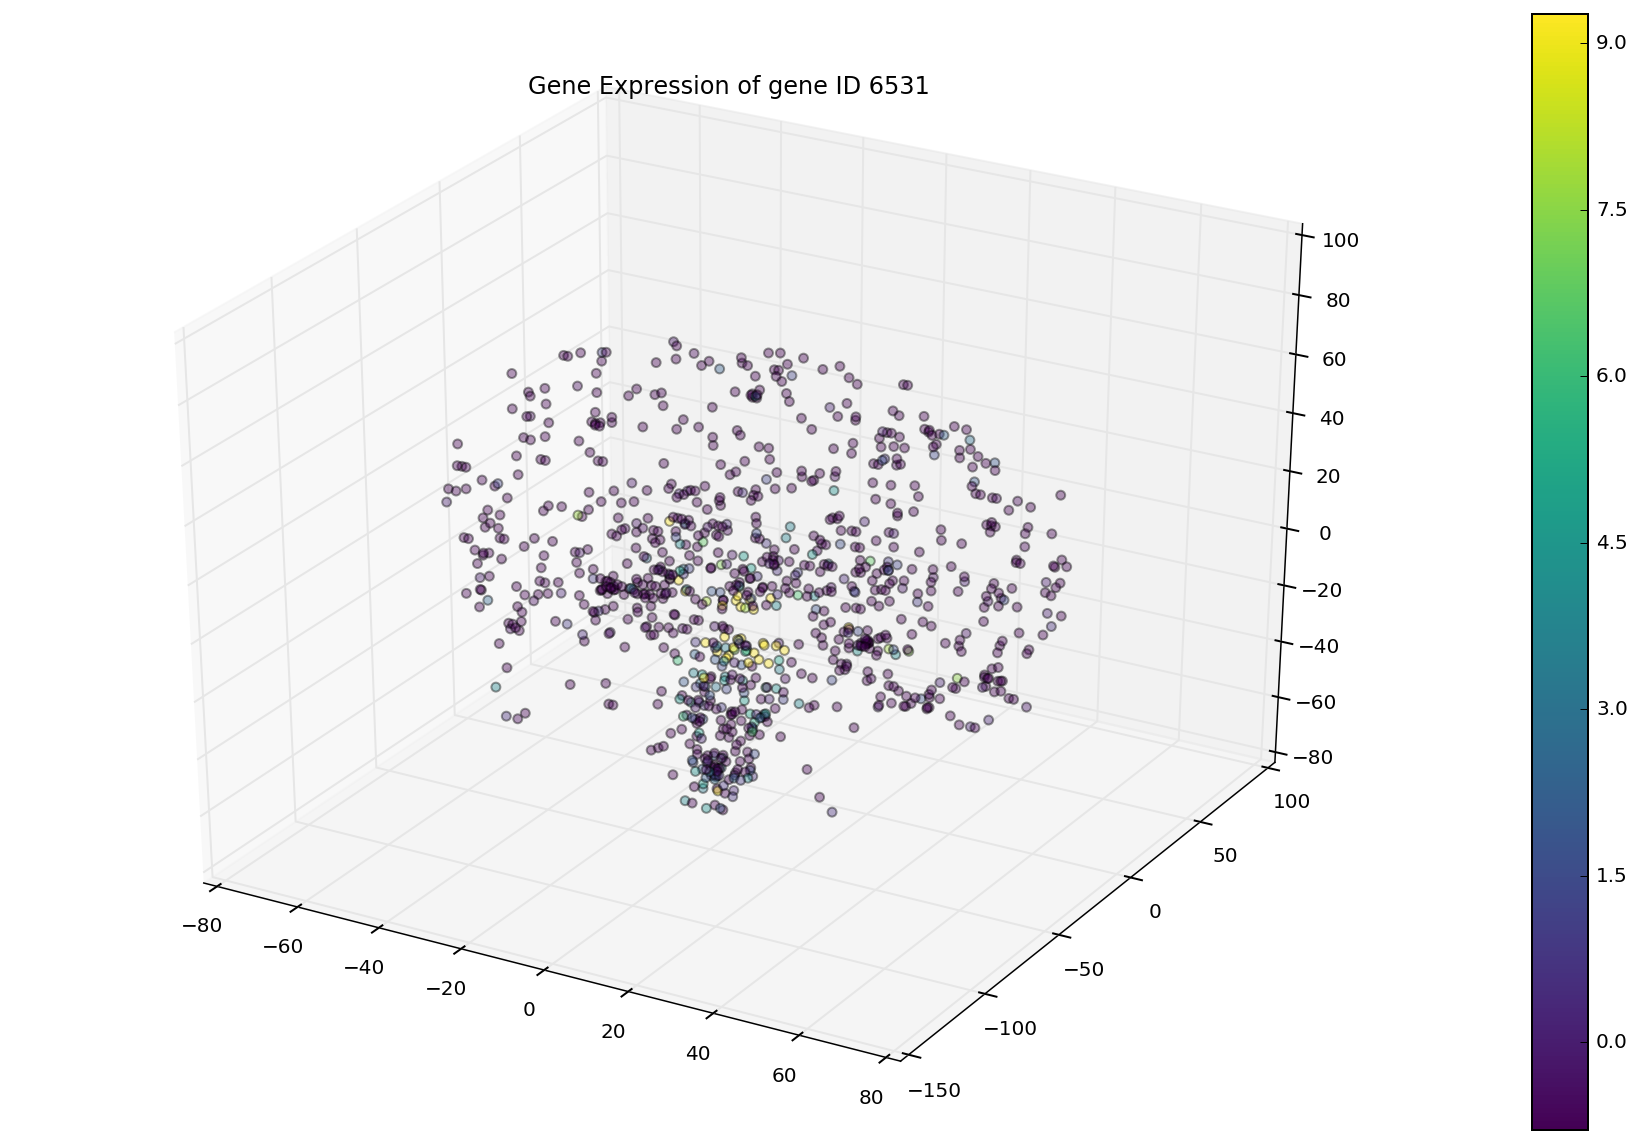

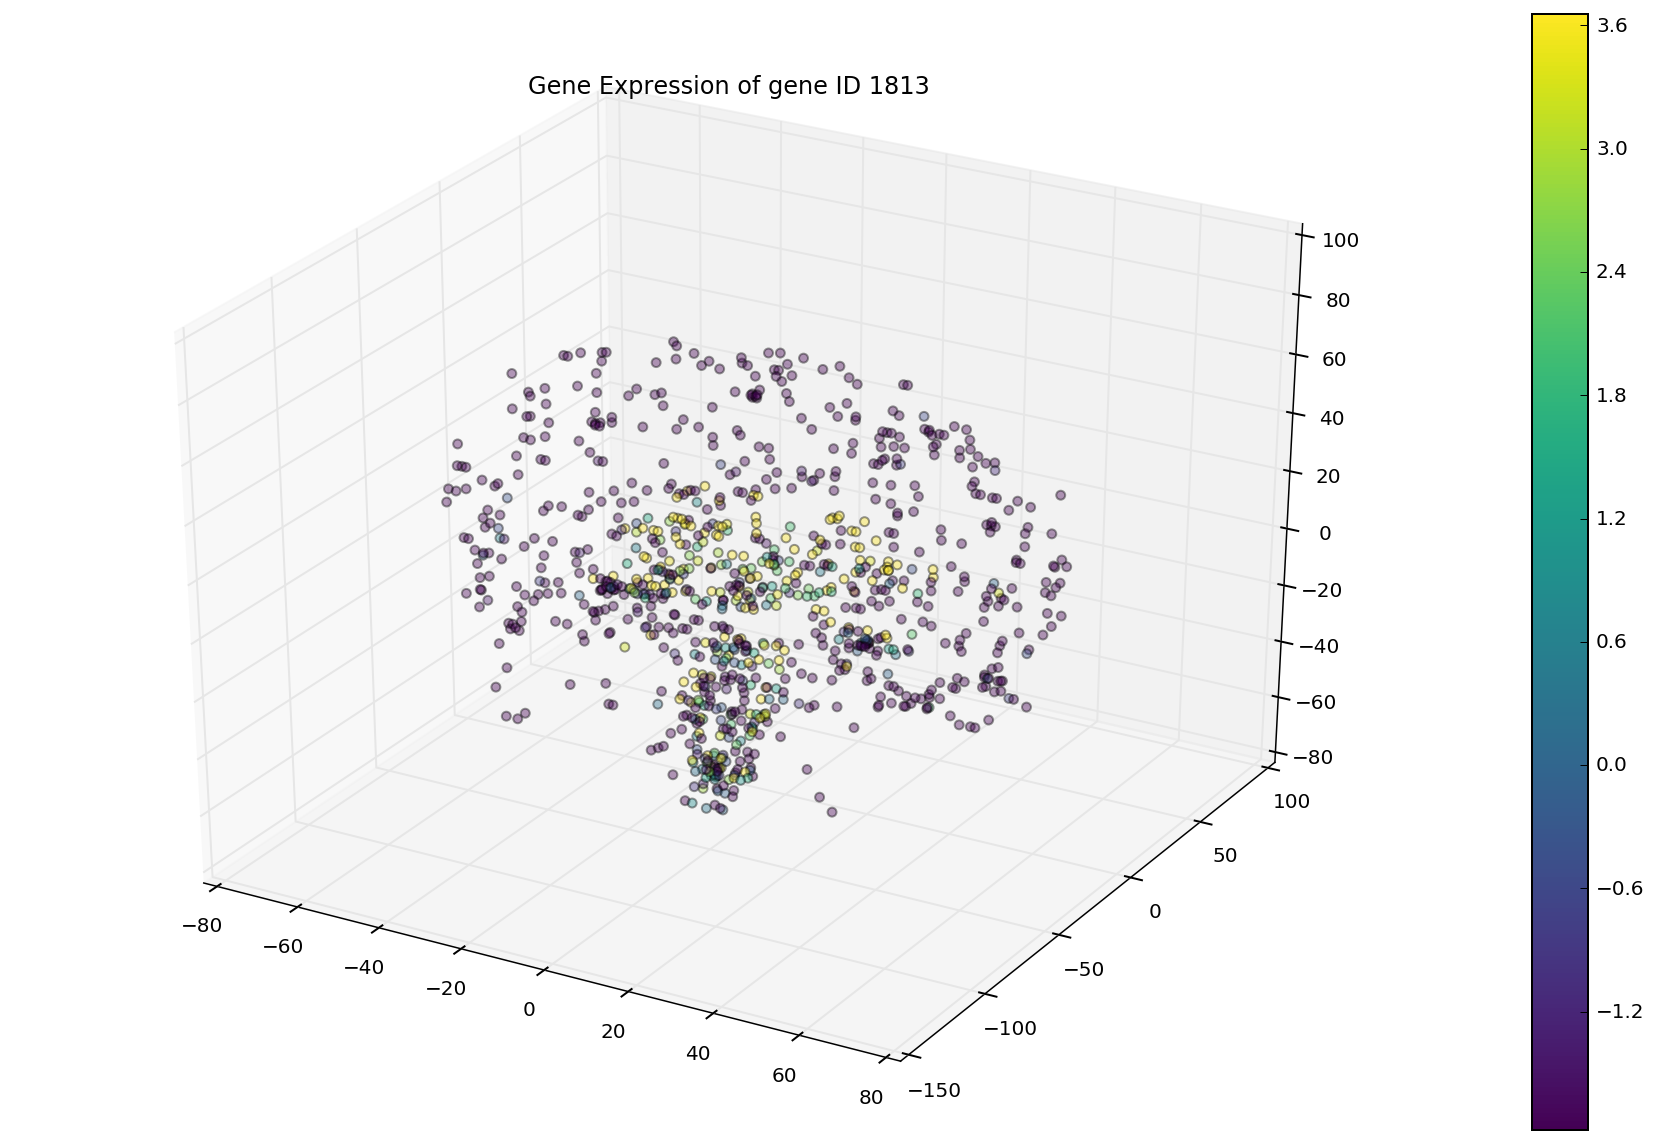

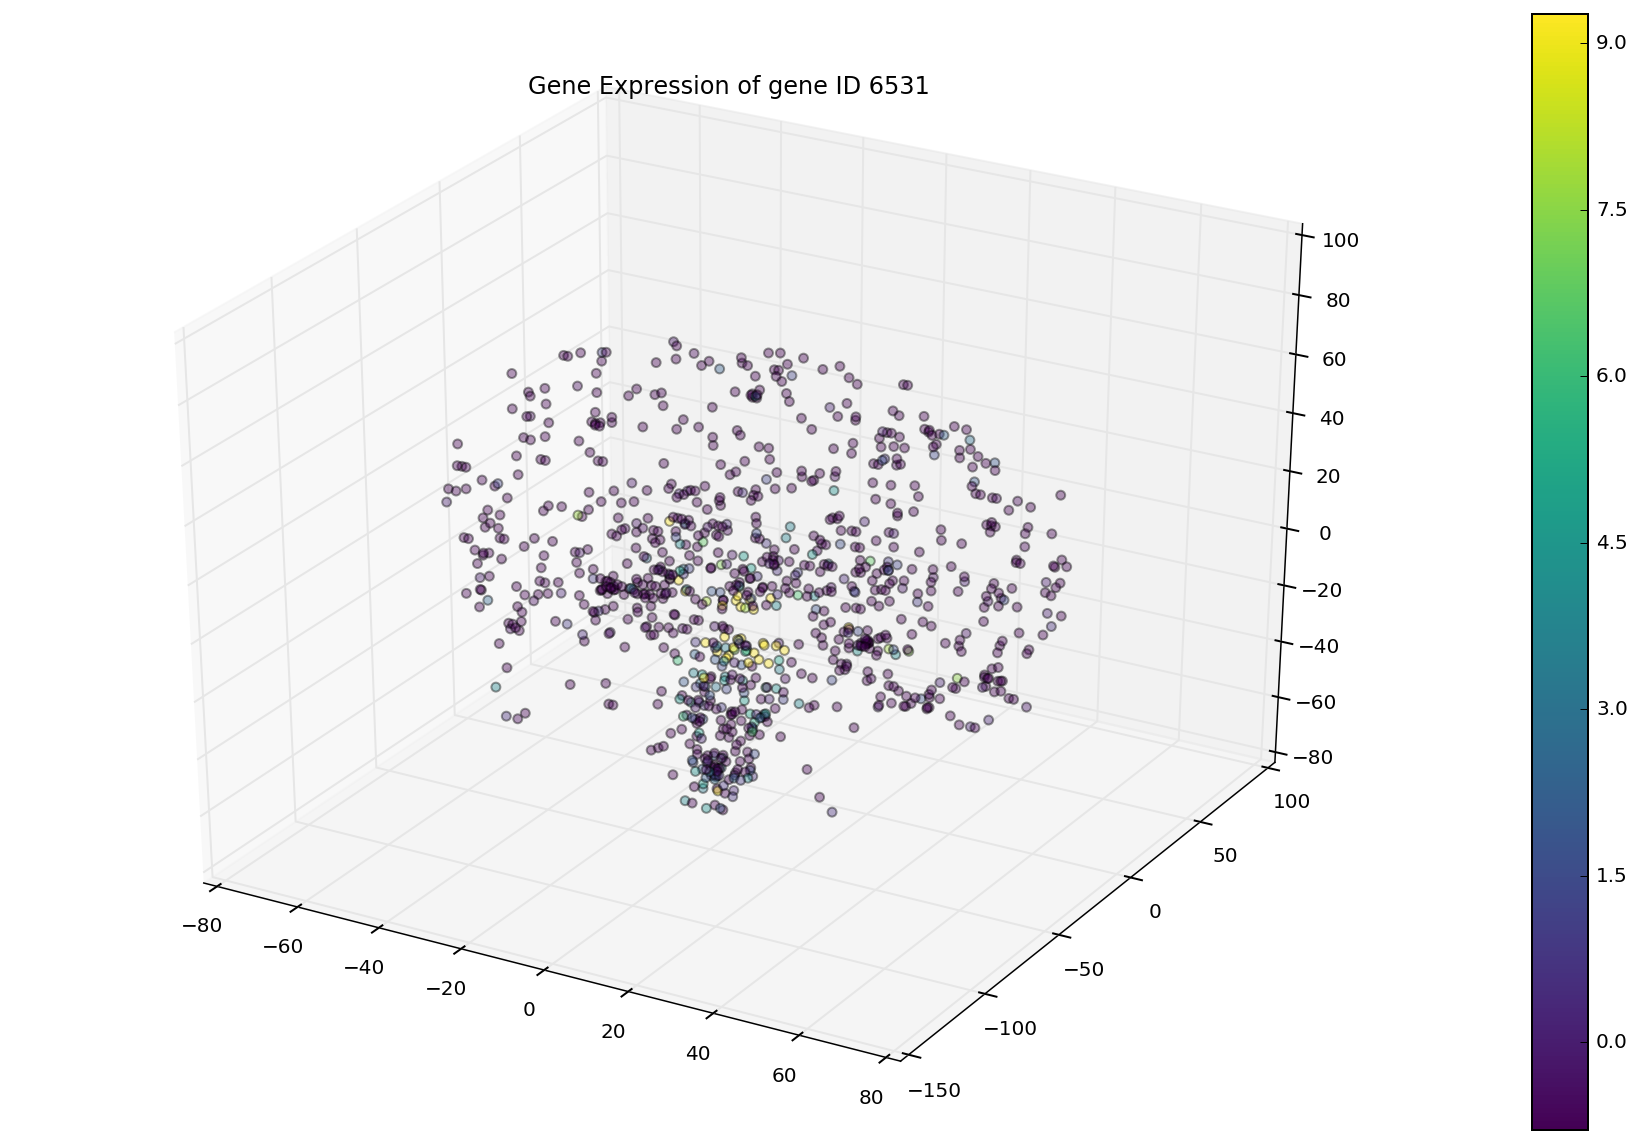

In [6]:
from nsaba.nsaba.visualizer import NsabaVisualizer
#different estimation methods can be used and visualized.

V = NsabaVisualizer(N)
V.visualize_ge(genes[0])
V.visualize_ge(genes[1])

### Visualizing activation of reward

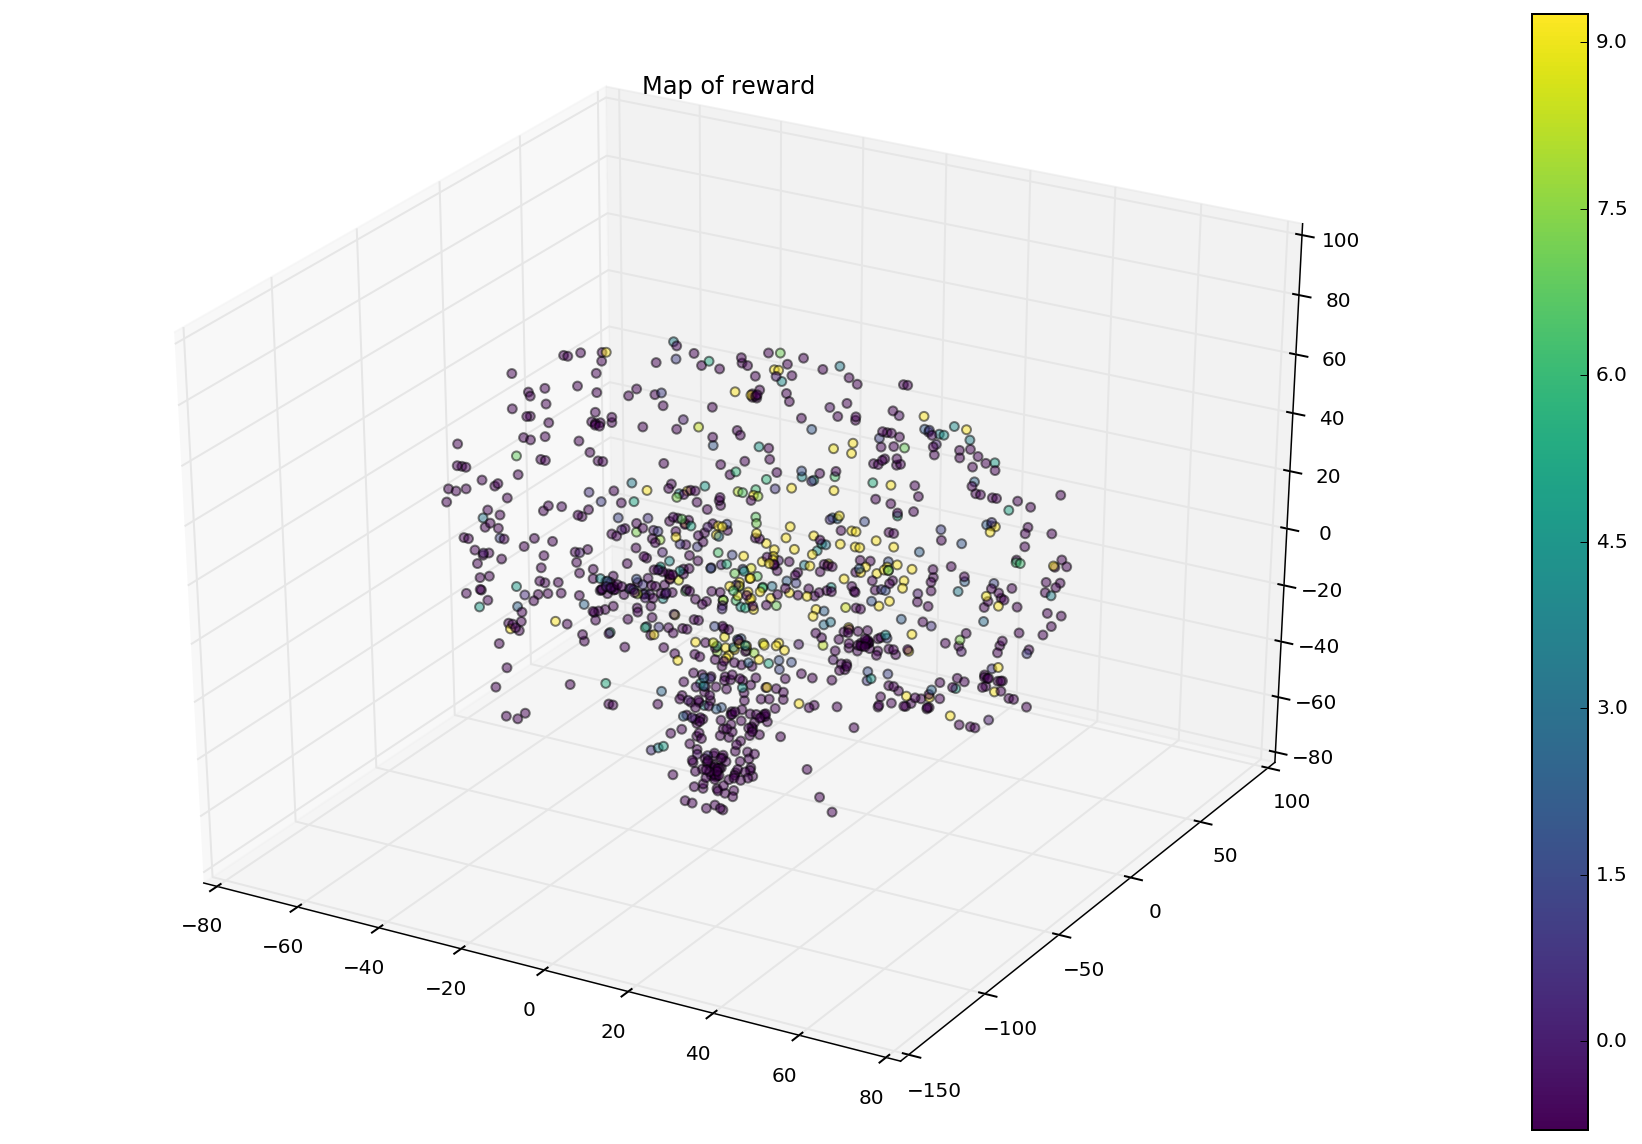

In [12]:
V.visualize_ns(term='reward',z_score=True);

<a id="Correlations"></a>
## Plotting the correlation between two genes

(array([[ 1.        ,  0.35283388],
        [ 0.35283388,  1.        ]]),
 [0.33555195928373605, 1.3717596592325352])

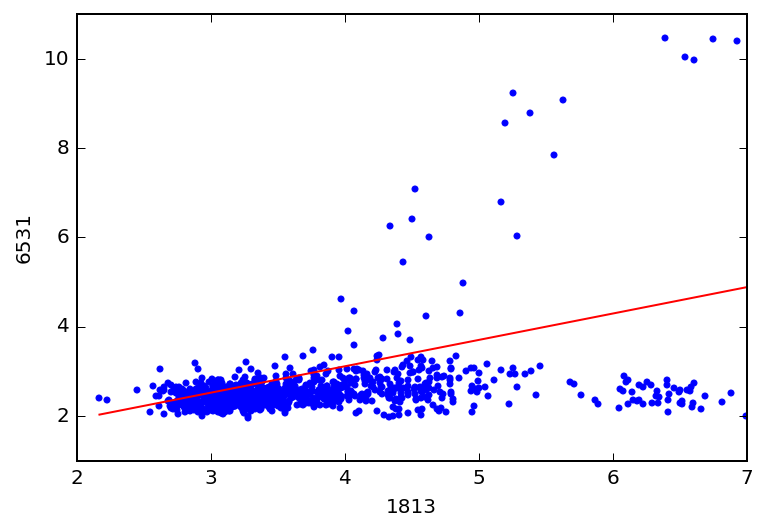

In [13]:
V.lstsq_ge_ge(genes[0],genes[1])

Interesting note:
We're plotting the gene expression of the D2 receptor and the dopamine transporter. The dopamine transporter isn't specific to D2. That's why we see a subset of the data correlating but not all of it.

### Plotting correlation between two terms
Extremely small NS values can cause the regression line to look strange

(array([[ 1.        ,  0.33808079],
        [ 0.33808079,  1.        ]]),
 [0.16643900107354223, 0.0005479373946146544])

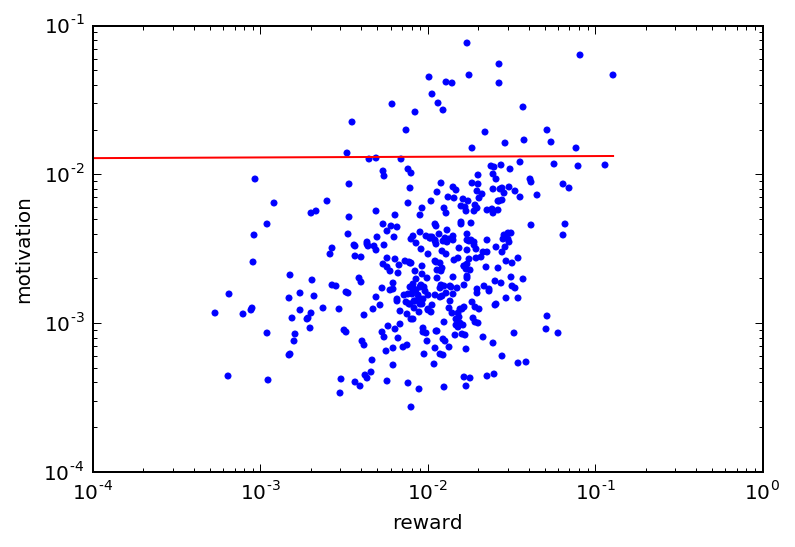

In [14]:
V.lstsq_ns_ns(term1,term2,logx=True,logy=True)

### Correlating activation of one term with expression of one gene

correlation: r=0.237571144521

linear regression: m=0.00338740765224 c=-0.00254598947594


([array([ 1.        ,  0.23757114]), array([ 0.23757114,  1.        ])],
 [0.0033874076522374657, -0.0025459894759409405])

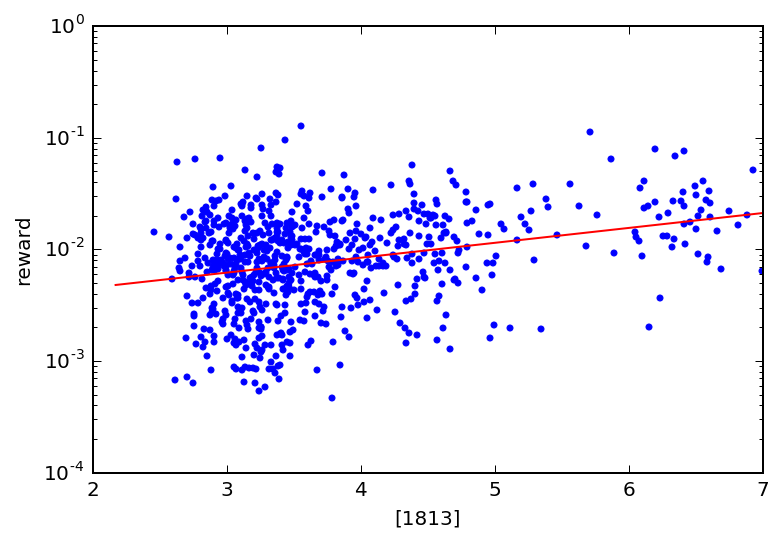

In [15]:
V.lstsq_ns_ge('reward',[genes[0]],logy=True,verbose=True)

We realized that linear correlations and regressions weren't capturing much of what was going on in the data so we built an analysis class to do more appropriate statistical analyses

<a id="Analysis"></a>
# The Analysis Module

* t_test(term, gene, quant, log, graphops): performs a t-test on gene expression of given gene between papers that use that word and papers that don't. A significant t-test indicates that gene expression levels are significantly different. How much a word is used can be modulated with quant (0-1). if log is set to True, the t-test is performed on logged data. graphops can be set to 'density', 'violin', or 'box' to make different helpful plots.

* t_test_multi(term, quant, sample_num, genes_of_interest): performs t-tests on all (subsample sample_num) gene expression of all genes (that have been initialized) between papers that use a term and papers that don't (as defined by quant).

* p_val_distr(ttest_metrics): uses the output from t_test_multi and plots the distribution of p_values for every  for every term/non-term gene expression comparison

* effect_size_distr(ttest_metrics): uses the output from t_test_multi and plots the distribution of effect_sizes (cohen's d) for every term/non-term gene expression comparison. We believe the effect size  of the t-test will be more informative about significance than p value.

* fetch_gene_discriptions(ttest_metrics, nih_fetch_num, alpha): querries the NIH database of gene information and returns information about the top n genes. Prints new significance value after Bonferroni Correction using alpha



### Performing t-test on gene expression of D2 receptor in regions associated with reward and brain regions not associated with reward

In [17]:
from nsaba.nsaba.analysis import NsabaAnalysis
N.estimate_ns_act(['reward'])
A = NsabaAnalysis(N)

To use inline plotting functionality in Jupyter, '%matplotlib inline' must be enabled


t-value: -6.8151 
p-value: 1.684E-11
Effect size: 0.7421
Control/Functional Split: 846/94



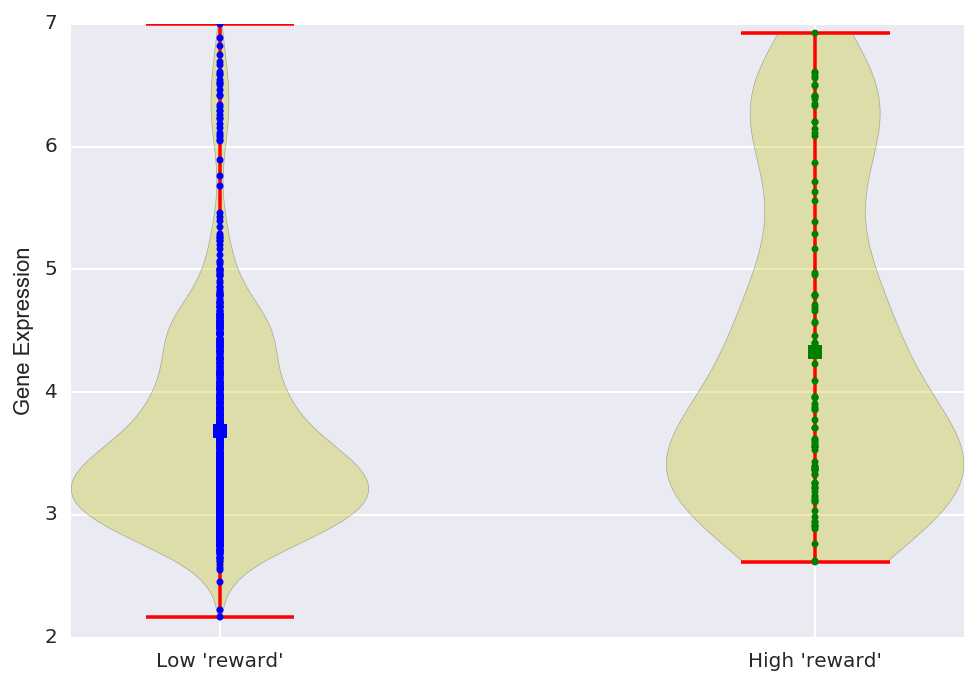

In [18]:
A.term_ge_ttest('reward',genes[0],graphops='violin',quant = 90)

t-value: -8.4754 
p-value: 8.994E-17
Effect size: 0.7754
Control/Functional Split: 799/141



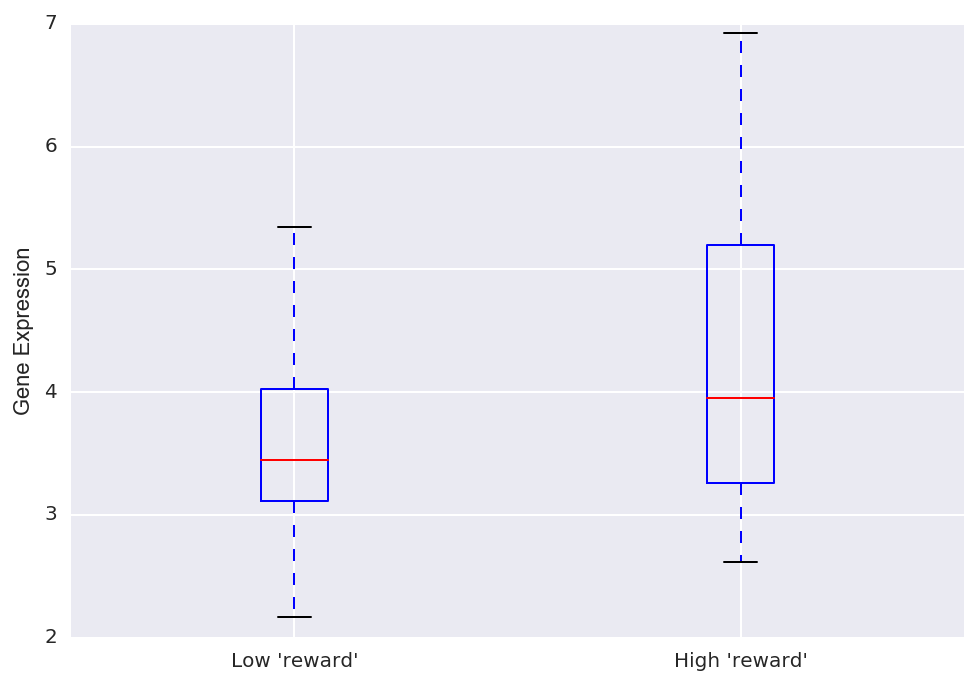

In [19]:
A.term_ge_ttest('reward',genes[0],graphops='box')

t-value: -6.1068 
p-value: 1.614E-09
Effect size: 0.9209
Control/Functional Split: 893/47



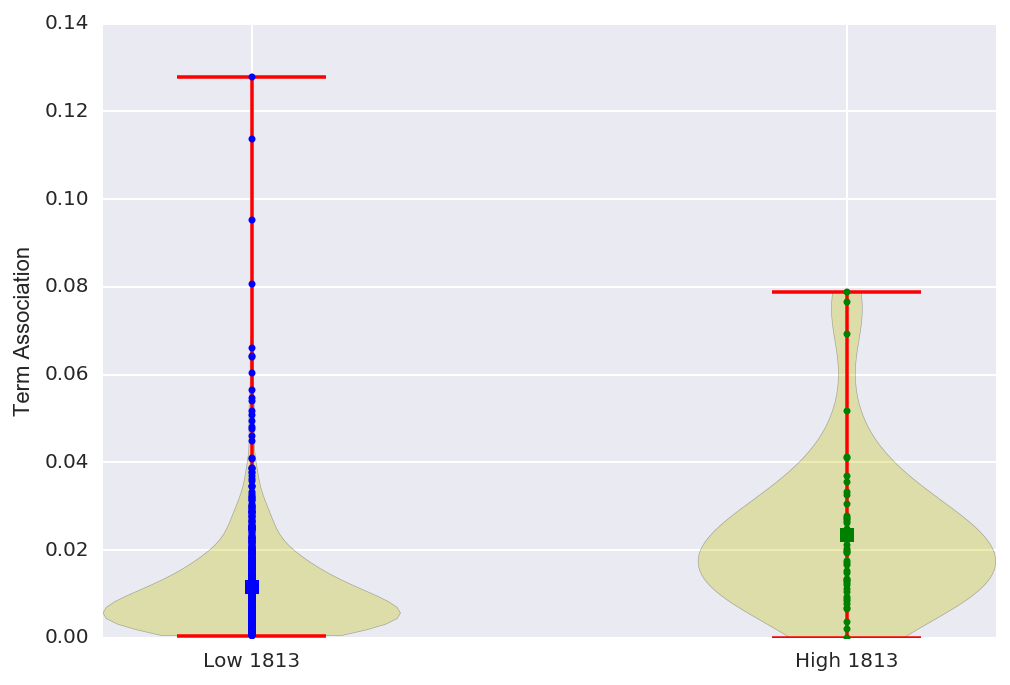

In [21]:
#N.estimate_ns_act('reward')
A.ge_term_ttest('reward',1813,graphops='violin',split_method ='quant',quant=95 )

### Performing t-tests on gene expression of *all genes* in regions associated with reward and brain regions not associated with reward

In [22]:
ttest_metrics = A.term_ge_ttest_multi('reward',quant=90)

This may take a couple of minutes ...


### Plotting effect size of all ttests

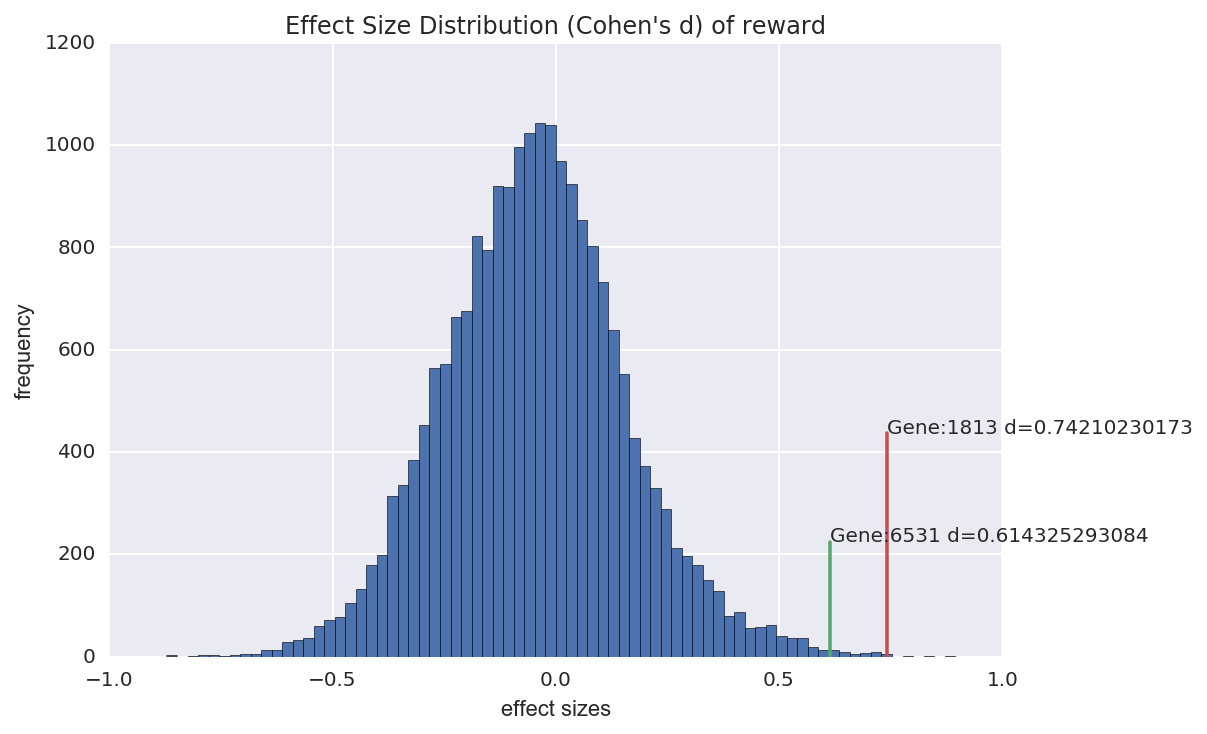

In [23]:
A.gene_cohen_d_distr(ttest_metrics,genes_of_interest=genes)

<a id="Scraping"></a>
## In the cell below, we querry the NIH database for the top 20 genes that were found to be associated with reward.

The 7th highest, out of 20,000 probes is the dopamine transporter and the 17th is the D2 receptor.


In [24]:
top_genes = A.fetch_gene_descriptions(ttest_metrics,csv_path='/Users/Torben/Code/nsaba/csv/')

Gene 6324 not found in NIH database
Gene 126433 not found in NIH database

Corrected Bonferroni Alpha: 2.405E-06


57478 (p = 3.534E-15; d = -0.872): No description found


8482 (p = 7.414E-15; d = -0.861): [u'The protein encoded by this gene binds to cell surfaces through a glycosylphosphatidylinositol (GPI) linkage. The encoded glycoprotein is found on activated lymphocytes and erythrocytes. This protein may be involved in immunomodulatory and neuronal processes. Defects in this gene can result in loss of bone mineral density (BMD). Three transcript variants encoding different isoforms have been found for this gene.[provided by RefSeq, Mar 2009]']


3949 (p = 2.970E-13; d = -0.806): [u'The low density lipoprotein receptor (LDLR) gene family consists of cell surface proteins involved in receptor-mediated endocytosis of specific ligands. Low density lipoprotein (LDL) is normally bound at the cell membrane and taken into the cell ending up in lysosomes where the protein is degraded and 

## Scraping Method
The discriptions for the genes in the list above were generated using methods from the geneinfo module. See below

In [28]:
#from nsaba.nsaba import geneinfo

#get information about given genes from the NIH gene database
gene_information = geneinfo.scrape_nih_gene_info(str(genes[0]))
print gene_information

#The GeneCards database can also be searched to find the entrez id of a 
#given gene using the following method:

#genecard_entrez_id = geneinfo.fetch_entrez_ids('DRD2',0)
#print genecard_entrez_id

(u'dopamine receptor D2', [u'This gene encodes the D2 subtype of the dopamine receptor. This G-protein coupled receptor inhibits adenylyl cyclase activity. A missense mutation in this gene causes myoclonus dystonia; other mutations have been associated with schizophrenia. Alternative splicing of this gene results in two transcript variants encoding different isoforms. A third variant has been described, but it has not been determined whether this form is normal or due to aberrant splicing. [provided by RefSeq, Jul 2008]'])


<a id="Builder"></a>
## Builder Module for Long Operations
Builds pkl files of term and gene estimations for later use. 

Runtimes can exceed 1 hr.

In [7]:
#from nsaba.nsaba import builder

#NB = builder.NsabaBuilder()
#NB.get_aba_ge_all()
#NB.pickle_ge(pkl_file="Nsaba_ABA_ge.pkl",output_dir='/Users/Torben/Documents/')

#NB.get_ns_act_all(inds=[1,3403])
#NB.pickle_ns(pkl_file='Nsaba_NS_act.pkl',output_dir='/Users/Torben/Documents/')